In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re

from ames_preprocessing import restrict_col_list, get_compressed_ames, transformed_df
from ames_model_helper import * 

import statsmodels.api as sm
from pingouin import ttest

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Import and clean

In [2]:
data = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col = 0).drop_duplicates().reset_index(drop = True)

## Manual adjustments

In [3]:
housing = data.copy()

#Do not appear to be legit garages; remove
housing.at[531,'GarageType'] = np.nan
housing.at[531,'GarageCars'] = np.nan
housing.at[531,'GarageArea'] = 0
housing.at[433, 'GarageType'] = np.nan

#Fill using known basement finish type
housing.at[2433, 'BsmtFinType2'] = housing.at[2433, 'BsmtFinType1']

#Fill missing exposure & electrical with most frequently occuring
housing.at[813, 'BsmtExposure'] = 'No'
housing.at[1201, 'BsmtExposure'] = 'No'
housing.at[2441, 'Electrical'] = 'SBrkr'

#Fix remodel year which makes no sense
housing.at[2033, 'YearRemodAdd'] = housing.at[2033, 'YearBuilt']

## Create cleaned/compressed dataset & feature lists

In [4]:
data_dict = get_compressed_ames(housing)

In [5]:
housing = data_dict['housing']
areas = data_dict['areas']
frontage = data_dict['frontage']
miscval = data_dict['miscval']
conditions = data_dict['conditions']
inspect10pt = data_dict['inspect10pt']
inspect5pt = data_dict['inspect5pt']
inspections = data_dict['inspections']
dates = data_dict['dates']
counts = data_dict['counts']
other_cats = data_dict['categoricals']

In [6]:
housing['remod_age'] = housing['YrSold'] - housing['YearRemodAdd']
housing.drop('YearRemodAdd', axis = 1, inplace = True)
dates = restrict_col_list(dates, housing)
dates.append('remod_age')

In [7]:
categoricals = other_cats+conditions+inspections
numeric = [x for x in housing.columns if x not in categoricals+['PID', 'SalePrice']]
assert set(housing[numeric].select_dtypes(include=np.number).columns) == set(numeric)

# Create training and test sets

In [8]:
features = housing.drop(['PID', 'SalePrice'], axis = 1)
target = housing.SalePrice

#Create train/test indices
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .3, random_state = 11)
train_idx = X_train.index
test_idx = X_test.index

# Dummifying

In [9]:
ohe = ColumnTransformer([
    #pass a list of column names which you want to pass through unaltered
    #The second coordinate is usually a transformer, but the keyword 'passthrough'
    #Just passes those columns instead.
    ('pass', 'passthrough', numeric),
    
    #pass a list of columns which you want to be OHE
    ('ohe', OneHotEncoder(drop = 'first', sparse = False), categoricals)
])

features_dummied = transformed_df(ohe,features)

X_train_dum = features_dummied.loc[train_idx,:]
X_test_dum = features_dummied.loc[test_idx,:]

# Inspect distribution

<AxesSubplot:>

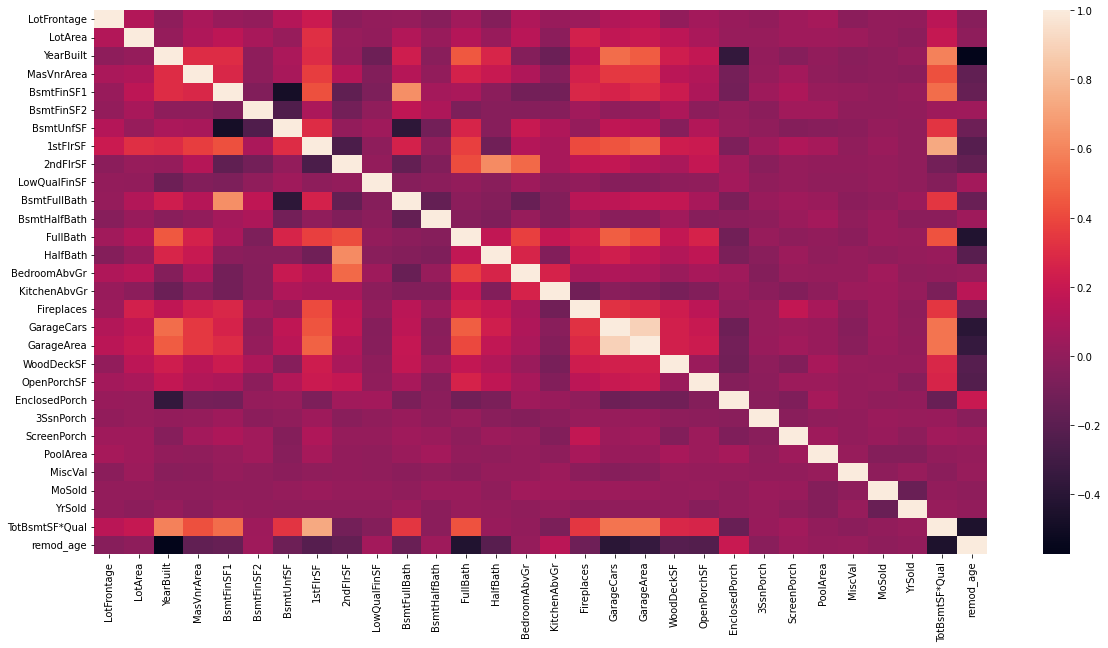

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(housing[[x for x in housing.columns if x not in categoricals+['PID', 'SalePrice']]].corr(), ax = ax)

# Baseline linear model

In [11]:
lm = LinearRegression()
lm.fit(X_train_dum,y_train)
print('Train score: %s' %lm.score(X_train_dum,y_train))
print('Test score: %s' %lm.score(X_test_dum,y_test))

Train score: 0.9323936709152545
Test score: 0.9203361923636806


In [12]:
print('Average validation score: %s' \
      % np.mean(cross_val_score(lm, X_train_dum, y_train, 
                                cv = 5)))

Average validation score: 0.8735238621253488


# Lasso for feature selection

## Tune Lasso

In [13]:
gslasso = GridSearchCV(Lasso(tol = .04), param_grid = {'alpha': 10.0 ** np.arange(-5,5)}, cv = 5, n_jobs = -1)
gslasso.fit(X_train_dum,y_train)
best_lasso = gslasso.best_estimator_

In [14]:
print(f'The best CV score was {gslasso.best_score_} using parameters {gslasso.best_params_}')

The best CV score was 0.8871115172236443 using parameters {'alpha': 100.0}


In [15]:
gslasso = GridSearchCV(Lasso(), param_grid = {'alpha': np.arange(100,1000,100)}, cv = 5, n_jobs = -1)
gslasso.fit(X_train_dum,y_train)
best_lasso = gslasso.best_estimator_

In [16]:
print(f'The best CV score was {gslasso.best_score_} using parameters {gslasso.best_params_}')

The best CV score was 0.8871103967802345 using parameters {'alpha': 100}


In [17]:
gslasso = GridSearchCV(Lasso(tol = .04), param_grid = {'alpha': np.arange(1,201,10)}, cv = 5, n_jobs = -1)
gslasso.fit(X_train_dum,y_train)
best_lasso = gslasso.best_estimator_

In [18]:
print(f'The best CV score was {gslasso.best_score_} using parameters {gslasso.best_params_}')

The best CV score was 0.887106891873105 using parameters {'alpha': 101}


In [19]:
gslasso = GridSearchCV(Lasso(), param_grid = {'alpha': np.arange(90,110,1)}, cv = 5, n_jobs = -1)
gslasso.fit(X_train_dum,y_train)
best_lasso = gslasso.best_estimator_

In [20]:
print(f'The best CV score was {gslasso.best_score_} using parameters {gslasso.best_params_}')

The best CV score was 0.8871103967802345 using parameters {'alpha': 100}


In [21]:
gslasso = GridSearchCV(Lasso(), param_grid = {'alpha': np.arange(99,101,.1)}, cv = 5, n_jobs = -1)
gslasso.fit(X_train_dum,y_train)
best_lasso = gslasso.best_estimator_

In [22]:
print(f'The best CV score was {gslasso.best_score_} using parameters {gslasso.best_params_}')

The best CV score was 0.8871104882008053 using parameters {'alpha': 99.89999999999995}


Does not improve significantly tuning any more precisely

In [23]:
lasso = Lasso(alpha = 100)
lasso.fit(X_train_dum,y_train)
print('Train score: %s' %lasso.score(X_train_dum,y_train))
print('Test score: %s' %lasso.score(X_test_dum,y_test))

Train score: 0.9203862715034566
Test score: 0.922006216515469


## Analyzing coefficients

In [24]:
#Get absolute size of each coefficient
lasso_coef = pd.DataFrame({'features': X_train_dum.columns, 
                           'coefs': lasso.coef_}).assign(size = np.abs(lasso.coef_))

<AxesSubplot:ylabel='Frequency'>

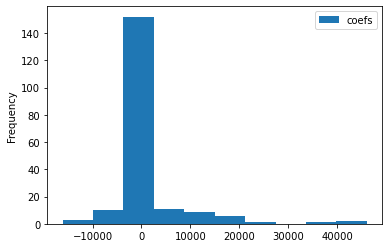

In [25]:
lasso_coef.sort_values(by='size', ascending=False).plot(kind = 'hist', x = 'size')

In [26]:
#drop columns whose coefficient was 0
lasso_drop = list((lasso_coef[lasso_coef['size'] == 0]).loc[:,'features'])
features_select = features_dummied.drop(lasso_drop,axis = 1)

X_select = features_select.loc[train_idx,:]
X_select_test = features_select.loc[test_idx,:]

numeric_select = restrict_col_list(numeric, X_select)
categorical_select = [x for x in X_select.columns if x not in numeric_select]

In [27]:
np.mean(cross_val_score(lasso, X_select, y_train, cv = 10))

0.8907874668184876

In [28]:
np.mean(cross_val_score(LinearRegression(), X_select, y_train, cv =10))

0.890202616394696

Selection increased CV score of regular linear regression by 2%

# Reduce linear dependence

In [29]:
dep_drop = recursive_dropping(X_select,y_train)

In [30]:
lasso_dep_drop = dep_drop + lasso_drop
lm = LinearRegression()
cross_val_score(lm, X_train_dum.drop(lasso_dep_drop, axis = 1), y_train).mean()

0.9039831490408725

In [31]:
estimate_dependence(X_train_dum.drop(lasso_dep_drop, axis = 1)).head(20)

,feature,R2
0,YearBuilt,0.823551
13,TotBsmtSF*Qual,0.817968
2,1stFlrSF,0.734425
32,BldgType_TwnhsE,0.711498
16,MSSubClass_120,0.691887
36,zoningGroups_norm_R,0.619176
14,remod_age,0.596559
48,OverallQual_9,0.580746
28,Neighborhood_OldTown,0.574711
1,BsmtFinSF1,0.563683


# Statsmodels test

In [32]:
lasso_dep_err_drop = lasso_dep_drop + ['MiscVal','MSSubClass_120', 'WoodDeckSF', 'Neighborhood_BrkSide', 'LotConfig_FR2', 'MoSold', 'LowQualFinSF',
                       'Neighborhood_Mitchel', 'GarageFinish_RFn', 'zoningGroups_norm_R']
lm = LinearRegression()
cross_val_score(lm, X_train_dum.drop(lasso_dep_err_drop, axis = 1), y_train).mean()

0.9026388747855381

In [33]:
smXselect = sm.add_constant(X_train_dum.drop(lasso_dep_err_drop, axis = 1))
model = sm.OLS(y_train,smXselect).fit()
smOLS_results(model).loc[1]

Result    R-squared:
Value          0.920
Name: 1, dtype: object

In [34]:
summary = smOLS_featurestats(model)
summary = summary.assign(variation = np.abs(summary['std err'] / summary ['coef']))
summary.sort_values(by = 'variation', ascending = False).head(10)

,variable,coef,std err,t,P>|t|,[0.025,0.975],variation
35,OverallQual_4,-4496.3449,2285.632,-1.967,0.049,-8979.193,-13.497,0.508331
18,Neighborhood_NWAmes,-5676.3889,2583.411,-2.197,0.028,-10700.000,-609.502,0.455115
11,remod_age,-99.9013,38.234,-2.613,0.009,-174.891,-24.912,0.382718
8,EnclosedPorch,23.0718,8.132,2.837,0.005,7.122,39.022,0.352465
17,Neighborhood_NAmes,-5375.6518,1682.358,-3.195,0.001,-8675.290,-2076.014,0.312959
49,HeatingQCGroups_pos_QC,4082.1786,1260.107,3.240,0.001,1610.711,6553.646,0.308685
44,OverallCond_6,4908.7445,1500.756,3.271,0.001,1965.286,7852.203,0.305731
43,OverallCond_4,-9829.2248,2985.200,-3.293,0.001,-15700.000,-3974.302,0.303707
36,OverallQual_5,-4801.6029,1449.868,-3.312,0.001,-7645.253,-1957.953,0.301955
13,MSSubClass_190,-11740.0000,3464.361,-3.390,0.001,-18500.000,-4948.250,0.295090


In [35]:
summary.variation.mean()

0.1991426799688491

In [36]:
# [x.strip() for x in summary[summary.variation >= .7].variable.values if (x.strip() != 'const')]

# Run models and metrics on selected features

In [37]:
features_select = features_dummied.drop(lasso_dep_err_drop,axis = 1)

X_select = features_select.loc[train_idx,:]
X_select_test = features_select.loc[test_idx,:]

numeric_select = restrict_col_list(numeric, X_select)
categorical_select = [x for x in X_select.columns if x not in numeric_select]

## Basic model stats

In [38]:
lm = LinearRegression()
lm.fit(X_select,y_train)
print(f'Train score: {lm.score(X_select,y_train)}')
print(f'Test score: {lm.score(X_select_test,y_test)}')

Train score: 0.9195785502227283
Test score: 0.9154228220302524


Train and test scores are close, indicating that the model is not overfitting.

In [39]:
print( f"""RMSE {np.std(target)/np.sqrt(mean_squared_error(y_test, lm.predict(X_select_test))):.2f} times smaller than overall standard deviation,
i.e., RMSE is {np.sqrt(mean_squared_error(y_test, lm.predict(X_select_test)))/np.std(target)*100:.2f}% of standard deviation""")

RMSE 3.28 times smaller than overall standard deviation,
i.e., RMSE is 30.45% of standard deviation


## Feature stats

In [40]:
smXselect = sm.add_constant(X_select)
model = sm.OLS(y_train,smXselect).fit()
smOLS_results(model).loc[1]

Result    R-squared:
Value          0.920
Name: 1, dtype: object

In [41]:
summary = smOLS_featurestats(model)
summary = summary.assign(variation = np.abs(summary['std err'] / summary ['coef']))
summary.sort_values(by = 'variation', ascending = False).head(10)

,variable,coef,std err,t,P>|t|,[0.025,0.975],variation
35,OverallQual_4,-4496.3449,2285.632,-1.967,0.049,-8979.193,-13.497,0.508331
18,Neighborhood_NWAmes,-5676.3889,2583.411,-2.197,0.028,-10700.000,-609.502,0.455115
11,remod_age,-99.9013,38.234,-2.613,0.009,-174.891,-24.912,0.382718
8,EnclosedPorch,23.0718,8.132,2.837,0.005,7.122,39.022,0.352465
17,Neighborhood_NAmes,-5375.6518,1682.358,-3.195,0.001,-8675.290,-2076.014,0.312959
49,HeatingQCGroups_pos_QC,4082.1786,1260.107,3.240,0.001,1610.711,6553.646,0.308685
44,OverallCond_6,4908.7445,1500.756,3.271,0.001,1965.286,7852.203,0.305731
43,OverallCond_4,-9829.2248,2985.200,-3.293,0.001,-15700.000,-3974.302,0.303707
36,OverallQual_5,-4801.6029,1449.868,-3.312,0.001,-7645.253,-1957.953,0.301955
13,MSSubClass_190,-11740.0000,3464.361,-3.390,0.001,-18500.000,-4948.250,0.295090


In [42]:
summary.variation.mean()

0.1991426799688491

The average coefficient of variation is about 20%, meaning that each estimate of the dollar value per unit feature was within 20% of the 'correct' value. 

In [43]:
smXtrain = sm.add_constant(X_train_dum)
model = sm.OLS(y_train,smXtrain).fit()
summary = smOLS_featurestats(model)
summary = summary.assign(variation = np.abs(summary['std err'] / summary ['coef']))
summary.variation.mean()

5.399277851998324

This is a massive improvement over the out-of-the-box model on all features, which has over 530% average coefficient of variation

## Compare to full model

As a descriptive model, we may also want to view the coefficients when fit to the entire dataset, now that we are convinced it does not overfit on these features.

In [44]:
smXselect_all = sm.add_constant(features_select)
model = sm.OLS(target,smXselect_all).fit()
smOLS_results(model).loc[1]

Result    R-squared:
Value          0.921
Name: 1, dtype: object

In [45]:
smOLS_featurestats(model).assign(variation = 
                                 np.abs(summary['std err'] / summary ['coef']))\
.sort_values('variation', ascending=False).head(10)

,variable,coef,std err,t,P>|t|,[0.025,0.975],variation
12,MSSubClass_90,-24600.0000,2576.621,-9.546,0.000,-29600.000,-19500.000,207.282849
0,const,-617900.0000,61000.000,-10.135,0.000,-738000.000,-498000.000,3.640553
48,ExterQual_4,19290.0000,3662.738,5.265,0.000,12100.000,26500.000,2.791600
47,OverallCond_9,27830.0000,3804.189,7.317,0.000,20400.000,35300.000,2.405656
45,OverallCond_7,13870.0000,1524.977,9.096,0.000,10900.000,16900.000,2.024441
35,OverallQual_4,-3861.9790,1905.952,-2.026,0.043,-7599.365,-124.594,1.827692
36,OverallQual_5,-3076.6694,1219.859,-2.522,0.012,-5468.695,-684.644,1.673374
20,Neighborhood_NridgHt,20670.0000,2550.252,8.104,0.000,15700.000,25700.000,1.607290
23,Neighborhood_StoneBr,38120.0000,3711.362,10.271,0.000,30800.000,45400.000,1.588041
31,functionalGroups_Typ,12970.0000,1803.985,7.191,0.000,9434.247,16500.000,1.417237


In [46]:
with open('drop_list.txt', 'w') as f:
    f.write(','.join(lasso_dep_err_drop))

There are some values which the model deems are significant which were thrown out.

In [47]:
with open('drop_list.txt', 'r') as f:
    drop_list = f.read().split(',')

In [48]:
smXtrain = sm.add_constant(X_train_dum)
model = sm.OLS(y_train,smXtrain).fit()

In [49]:
hyp = ' , '.join([f'({x} = 0)' for x in drop_list])
model.f_test(hyp)

/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 146, but rank is 142
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=2.6130763263095784, p=2.499545835745144e-19, df_denom=1.61e+03, df_num=142>

In [50]:
partialF = pd.DataFrame(zip(drop_list,[model.f_test(f'{x} = 0').pvalue for x in drop_list]), columns = ['feature', 'partial F'])

In [51]:
partialF[partialF['partial F'] < .05].shape[0]

23

In [52]:
bigger_model = sm.OLS(y_train, sm.add_constant(X_train_dum.drop(partialF[partialF['partial F'] >= .05].feature.values, axis = 1))).fit()
summary = smOLS_featurestats(bigger_model)
summary = summary.assign(variation = np.abs(summary['std err'] / summary ['coef']))
summary.sort_values(by = 'variation', ascending = False).head(10)

,variable,coef,std err,t,P>|t|,[0.025,0.975],variation
38,BldgType_Twnhs,14580.0000,12500.000,1.170,0.242,-9867.925,39000.000,0.857339
26,LandSlope_Sev,-14620.0000,10400.000,-1.405,0.160,-35000.000,5792.519,0.711354
39,BldgType_TwnhsE,17290.0000,12200.000,1.415,0.157,-6668.844,41300.000,0.705610
11,KitchenAbvGr,-7112.9709,4612.795,-1.542,0.123,-16200.000,1934.256,0.648505
56,cond2groups_normal,10310.0000,6605.715,1.561,0.119,-2641.915,23300.000,0.640710
53,SaleCondGroups_neg_cond,-9345.7900,5665.151,-1.650,0.099,-20500.000,1765.458,0.606171
9,HalfBath,2501.5424,1369.149,1.827,0.068,-183.815,5186.899,0.547322
30,Neighborhood_Mitchel,-5257.7267,2618.392,-2.008,0.045,-10400.000,-122.188,0.498008
20,MSSubClass_150,-50200.0000,24200.000,-2.079,0.038,-97600.000,-2833.704,0.482072
58,OverallQual_4,-4647.2264,2220.954,-2.092,0.037,-9003.258,-291.195,0.477910


In [53]:
smXselect = sm.add_constant(X_train_dum.drop(drop_list,axis = 1))
model = sm.OLS(y_train,smXselect).fit()
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,model.predict(sm.add_constant(X_test_dum.drop(drop_list, axis = 1))))):.2f}')
smOLS_results(model).iloc[[1,3,10,12],:]

Test RMSE: 22846.01


,Result,Value
1,R-squared:,0.920
3,Adj. R-squared:,0.917
9,AIC:,4.112e+04
11,BIC:,4.140e+04


In [54]:
print(f"""Test RMSE: {np.sqrt(mean_squared_error(y_test,bigger_model.predict(sm.add_constant(
X_test_dum.drop(partialF[partialF['partial F'] >= .05].feature.values, axis = 1))))):.2f}""")
smOLS_results(bigger_model).iloc[[1,3,10,12],:]

Test RMSE: 22411.45


,Result,Value
1,R-squared:,0.927
3,Adj. R-squared:,0.924
9,AIC:,4.099e+04
11,BIC:,4.138e+04


In [55]:
smXtrain = sm.add_constant(X_train_dum)
model = sm.OLS(y_train,smXtrain).fit()
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,model.predict(sm.add_constant(X_test_dum)))):.2f}')
smOLS_results(model).iloc[[1,3,10,12],:]

Test RMSE: 22172.48


,Result,Value
1,R-squared:,0.932
3,Adj. R-squared:,0.924
9,AIC:,4.109e+04
11,BIC:,4.214e+04


Full drop might be better for an interpretable model: 
7 are insignificantly different from 0 in the larger model, and dropping all from the drop list only leads to .7% drop in R2.

However, there is theoretical support for the partial drop model; there is a drop in AIC/BIC compared to full feature model, but also compared to the model dropping all from drop list. In fact, the full drop model has an increase in AIC, though drop in BIC compared to original. 

Can we remove the ones which are not significant?

In [56]:
bigger_model = sm.OLS(y_train, sm.add_constant(X_train_dum.drop(partialF[partialF['partial F'] >= .05].feature.values, axis = 1))).fit()
summary = smOLS_featurestats(bigger_model)
summary = summary.assign(variation = np.abs(summary['std err'] / summary ['coef']))
exclude = [x.strip() for x in summary[summary.variation>.5].variable.values]

middle_model = sm.OLS(y_train, sm.add_constant(X_train_dum.drop(list(partialF[partialF['partial F'] >= .05].feature.values) + exclude, axis = 1))).fit()
smOLS_results(middle_model).iloc[[1,3,10,12],:]

,Result,Value
1,R-squared:,0.926
3,Adj. R-squared:,0.924
9,AIC:,4.099e+04
11,BIC:,4.134e+04


This does show drop in AIC/BIC compared to middle model, but shows that other features insignificant. Remove these as well

# Update feature list based on AIC/BIC

In [57]:
middle_model = sm.OLS(y_train, sm.add_constant(X_train_dum.drop(
    list(partialF[partialF['partial F'] >= .05].feature.values)
    + exclude 
    + ['MSSubClass_150', 'Neighborhood_Mitchel'], axis = 1)) 
                     ).fit() 
smOLS_results(middle_model).iloc[[1,3,10,12],:]

summary = smOLS_featurestats(middle_model)
summary = summary.assign(variation = np.abs(summary['std err'] / summary ['coef']))
# summary.sort_values(by = 'variation', ascending = False).head(20)

In [58]:
smOLS_results(middle_model).iloc[[1,3,10,12],:]

,Result,Value
1,R-squared:,0.926
3,Adj. R-squared:,0.923
9,AIC:,4.099e+04
11,BIC:,4.133e+04


Retains AIC/BIC drop compared to full drop list.

In [59]:
updated_drop_list = list(partialF[partialF['partial F'] >= .05].feature.values)\
                    + exclude\
                    + ['MSSubClass_150', 'Neighborhood_Mitchel']

In [60]:
features_select = features_dummied.drop(updated_drop_list,axis = 1)

X_select = features_select.loc[train_idx,:]
X_select_test = features_select.loc[test_idx,:]

numeric_select = restrict_col_list(numeric, X_select)
categorical_select = [x for x in X_select.columns if x not in numeric_select]

In [61]:
lm = LinearRegression()
lm.fit(X_select,y_train)
print(f'Train score: {lm.score(X_select,y_train)}')
print(f'Test score: {lm.score(X_select_test,y_test)}')
print(f'\nTrain RMSE: {np.sqrt(mean_squared_error(y_train,lm.predict(X_select))):.2f}')
print(f'Train SD: {np.std(y_train):.2f}')
print(f'\nTest RMSE: {np.sqrt(mean_squared_error(y_test,lm.predict(X_select_test))):.2f}')
print(f'Test SD: {np.std(y_test):.2f}')

Train score: 0.9260679149251947
Test score: 0.9182223122004821

Train RMSE: 19974.59
Train SD: 73461.78

Test RMSE: 22464.73
Test SD: 78556.80


Slight increase to test score, still does not show overfitting (less than percent difference in R2). Only about \\$50 worse RMSE on test data compared to the bigger model, but about \\$400 better than smallest model.

In [62]:
with open('updated_drop_list.txt', 'w') as f:
    f.write(','.join(updated_drop_list))

## Evaluate

In [63]:
with open('updated_drop_list.txt', 'r') as f:
    drop_list = f.read().split(',')
    
features_select = features_dummied.drop(drop_list,axis = 1)

X_select = features_select.loc[train_idx,:]
X_select_test = features_select.loc[test_idx,:]

numeric_select = restrict_col_list(numeric, X_select)
categorical_select = [x for x in X_select.columns if x not in numeric_select]

In [64]:
lm_select = LinearRegression()
lm_select.fit(X_select,y_train)
pred_select = lm_select.predict(X_select_test)
print(f'Train score: {lm_select.score(X_select,y_train)}')
print(f'Test score: {r2_score(y_test, pred_select)}')

Train score: 0.9260679149251947
Test score: 0.9182223122004821


In [65]:
select_mae = mae(y_test, pred_select)
null_mae = mae(y_test, y_train.mean() * np.ones_like(y_test))
print(f'Select MAE: {select_mae}')
print(f'Null MAE: {null_mae}')
print(f'Improvement: {null_mae-select_mae}')

NameError: name 'mae' is not defined

In [ ]:
select_model = sm.OLS(y_train,sm.add_constant(X_select)).fit()
smOLS_results(select_model)

In [ ]:
y_pred = select_model.predict(sm.add_constant(X_select_test))
print(f'R2 Test: {r2_score(y_pred,y_test) :.4f}')

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
std = np.std(y_test)
print(f'Test RMSE: {rmse:.2f}')
print(f'Test SD: {std:.2f}')
std-rmse

In [ ]:
big_errors = np.sqrt((y_test - y_pred) ** 2).sort_values(ascending = False).head(10).index

plt.scatter(x = y_pred, y = y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle = '--', color = 'black')
plt.scatter(x = y_pred[big_errors], y = y_test[big_errors])

Of the top 10 with largest RMSE, 4 are amongst the most expensive houses on the market (outliers).
The RMSE drops by 3k when these 4 houses alone are excluded, and r2 increases by 2%.

In [ ]:
expensive = y_test.sort_values(ascending=False).head(4).index
np.sqrt(mean_squared_error(y_pred[~y_pred.index.isin(expensive)],y_test[~y_pred.index.isin(expensive)]))

In [ ]:
r2_score(y_pred[~y_pred.index.isin(expensive)],y_test[~y_pred.index.isin(expensive)])

In [ ]:
summary = smOLS_featurestats(select_model)
summary = summary.assign(variation = np.abs(summary['std err'] / summary ['coef']))
summary.sort_values('coef', ascending = False).head(38)

In [ ]:
summary.sort_values('coef', ascending = False).tail(26)

In [ ]:
summary.variation.mean()

In [ ]:
summary['P>|t|'].max()

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

## Visualize Coefs

In [ ]:
sns.barplot(data = summary.drop(0, axis = 0).sort_values('coef', ascending = False), x = 'coef', y = 'variable')

Too chaotic; try separating categoricals since on very different scale

### Categorical

In [ ]:
sorted(list({x.split('_')[0] for x in categorical_select}))

#### Basement

In [ ]:
data = summary[summary.variable.str.strip().apply(lambda x: True if re.search('Bsmt', x) else False)]\
                .sort_values('coef', ascending = False)
# data['variable'] = data.variable.apply(lambda x: x.split('_')[1].strip())
fig, ax = plt.subplots(figsize = (5,4))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr =  data['std err'])

#### Exterior type

In [ ]:
data = summary[summary.variable.str.strip().apply(lambda x: True if re.search('ext', x) else False)]\
                .sort_values('coef', ascending = False)
# data['variable'] = data.variable.apply(lambda x: x.split('_')[1].strip())
fig, ax = plt.subplots(figsize = (5,4))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr =  data['std err'])

#### Neighborhoods

In [ ]:
text = """Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       Greens	Greens
       GrnHill	Green Hills
       IDOTRR	Iowa DOT and Rail Road
       Landmrk	Landmark
       MeadowV	Meadow Village
       Mitchel	Mitchell
       NAmes	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker"""

neigh_key = {a[0].strip():a[1].strip() for a in [x.split('\t') for x in text.split('\n')]}

In [ ]:
data = summary[summary.variable.apply(lambda x: x.split('_')[0].strip() == 'Neighborhood')].sort_values('coef', ascending = False)
data['variable'] = data.variable.apply(lambda x: neigh_key[x.split('_')[1].strip()])
fig, ax = plt.subplots(figsize = (5,4))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr =  data['std err'])

#### MSSubClass

In [ ]:
text = """020	1-STORY 1946 & NEWER ALL STYLES
       030	1-STORY 1945 & OLDER
       040	1-STORY W/FINISHED ATTIC ALL AGES
       045	1-1/2 STORY - UNFINISHED ALL AGES
       050	1-1/2 STORY FINISHED ALL AGES
       060	2-STORY 1946 & NEWER
       070	2-STORY 1945 & OLDER
       075	2-1/2 STORY ALL AGES
       080	SPLIT OR MULTI-LEVEL
       085	SPLIT FOYER
       090	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES"""

subclass_key = {int(a[0]):a[1].strip() for a in [x.split('\t') for x in text.split('\n')]}

In [ ]:
data = summary[summary.variable.apply(lambda x: x.split('_')[0].strip() == 'MSSubClass')].sort_values('coef', ascending = False)
data['variable'] = data.variable.apply(lambda x: subclass_key[int(x.split('_')[1])])
fig, ax = plt.subplots(figsize = (5,4))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr =  data['std err'])

#### Overall Condition

In [ ]:
data = summary[summary.variable.apply(lambda x: x.split('_')[0].strip() == 'OverallCond')].sort_values('coef', ascending = False)
data['variable'] = data.variable.str.strip().apply(lambda x: f"Overall Condition: {x.split('_')[1].strip()}")
fig, ax = plt.subplots(figsize = (7,4))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr =  data['std err'])

#### Overall Quality

In [ ]:
data = summary[summary.variable.apply(lambda x: x.split('_')[0].strip() == 'OverallQual')].sort_values('coef', ascending = False)
data['variable'] = data.variable.str.strip().apply(lambda x: f"Overall Quality: {x.split('_')[1].strip()}")
fig, ax = plt.subplots(figsize = (5,4))
sns.barplot(data = data,
            x = 'coef', y = 'variable', xerr = data['std err'], ax = ax)

#### One offs

In [ ]:
data = summary[summary.variable.str.strip().apply(lambda x: True if re.search('ExterQual|GarageFinish|Heating|Land|Sale|functional|zoning|cond[1,2]groups', x) else False)]\
                .sort_values('coef', ascending = False)
# data['variable'] = data.variable.apply(lambda x: x.split('_')[1].strip())
fig, ax = plt.subplots(figsize = (5,6))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr =  data['std err'])

In [ ]:
summary[summary.variable.str.strip().str.contains('cond2')]

### Numeric

#### Areas

In [ ]:
data = summary[summary.variable.apply(lambda x: (x.strip() in areas) and (x.strip() not in ['LotArea']))].sort_values('coef', ascending = False)
fig, ax = plt.subplots(figsize = (5,4))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr = data['std err'])

In [ ]:
features['1stFlrSF'].mean() * summary[summary.variable.str.strip() == '1stFlrSF'].coef.values[0]\
+ features['2ndFlrSF'].mean() * summary[summary.variable.str.strip() == '2ndFlrSF'].coef.values[0] 

In [ ]:
target.mean()

In [ ]:
summary.loc[0,:]

In [ ]:
# data = summary[summary.variable.str.strip() == 'MasVnrArea'].sort_values('coef', ascending = False)
# fig, ax = plt.subplots(figsize = (5,1))
# sns.barplot(data = data,
#             x = 'coef', y = 'variable', ax = ax, xerr = data['std err'])

#### Dates

In [ ]:
data = summary[summary.variable.str.strip().apply(lambda y: y in dates)].sort_values('coef', ascending = False)
fig, ax = plt.subplots(figsize = (5,1))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr = data['std err'])

The year has a very strong effect, and we might think that the constant offsets this

In [ ]:
features.YearBuilt.mean() * summary[summary.variable.str.strip() == 'YearBuilt'].coef.values[0]

In [ ]:
features.YearBuilt.mean() * summary[summary.variable.str.strip() == 'YearBuilt'].coef.values[0]\
+ summary.loc[0,'coef']

In [ ]:
features.remod_age.mean() * summary[summary.variable.str.strip() == 'remod_age'].coef.values[0]

#### Counts

In [ ]:
data = summary[summary.variable.str.strip().apply(lambda y: y in counts)].sort_values('coef', ascending = False)
fig, ax = plt.subplots(figsize = (5,1))
sns.barplot(data = data,
            x = 'coef', y = 'variable', ax = ax, xerr = data['std err'])

In [ ]:
plt.scatter(x = features.BedroomAbvGr, y = target)

In [ ]:
sns.boxplot(data = features, x = 'MSSubClass', y = 'BedroomAbvGr')

In [ ]:
plt.scatter(x = features.remod_age, y = features.OverallQual)
plt.scatter(x = features.remod_age, y = features.OverallCond)